In [1]:
import matplotlib
matplotlib.use('TkAgg')  # avoid non-GUI warning for matplotlib
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, HTML
from itertools import product as cartesian_product
from skimage.draw import circle, circle_perimeter

from utils import *

%matplotlib inline
np.set_printoptions(linewidth=250,precision=2)

## Environment Definition

In [2]:
class MazeGenerator(object):
    def __init__(self):
        self.maze = None
    
    def init_end_states(self):
        """Get start and end goals"""
        init_state = [3,1]
        goal_states = [[11,17]]
        return init_state, goal_states
        
    def get_maze(self):
        return self.maze


class SimpleMazeGenerator(MazeGenerator):
    def __init__(self, maze):
        super().__init__()
        
        self.maze = maze

In [3]:
#Region ID's (also related to the region colours, more in utils.py - line 113)
regions = {'water':6, 'edge':7, 'sky':8, 'mine':4, 'uncharted':5}

env_size = 19
maze_array = np.zeros([env_size,env_size]) + regions['water']

#Boundary
maze_array[:,0] = regions['edge']
maze_array[:,-1] = regions['edge']
maze_array[-1,:] = regions['edge']
maze_array[0:2,:] = regions['sky']

#Bombs
maze_array[circle(11,3,2)] = regions['mine']
maze_array[circle(6,14,2)] = regions['mine']
maze_array[circle(15,4,2)] = regions['mine']
maze_array[circle(5,10,2)] = regions['mine']
maze_array[circle(13,16,2)] = regions['mine']
maze_array[circle(4,4,2)] = regions['mine']

#Unmapped territory
maze_array[circle(12,10,5)] = regions['uncharted']


In [4]:
#Generate the underwater maze environment
maze = SimpleMazeGenerator(maze_array)
submarine = MazeEnv(maze, render_trace=True)

## Brief Introduction

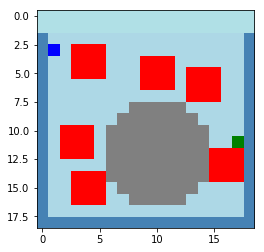

In [5]:
# A view of the environment

#reset(), resets the environment back to it's initial conditions and returns a view of it
snapshot = submarine.reset() 

plt.imshow(snapshot, cmap=submarine.cmap, norm=submarine.norm)

In [6]:
# Some available information from the environment
print("Number of Actions : ", submarine.num_actions,
      "\nAction ID: Up, Down, Left, Right = ",submarine.all_actions,
     "\nGoal states: ", submarine.goal_states,
      "\nMaze size: ", submarine.maze_size,
     "\nList of all states in the environment: ", submarine.valid_states[0:5], "...")

Number of Actions :  4 
Action ID: Up, Down, Left, Right =  [0, 1, 2, 3] 
Goal states:  [[11, 17]] 
Maze size:  (19, 19) 
List of all states in the environment:  [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)] ...


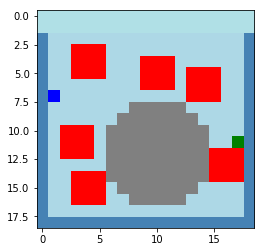

In [7]:
#Unlike the traditional gym environment, each call to the step() function executes an action and takes a step through the dynamics of the environment.
#The resulting environmental observation is returned. Note: This function updates the state of the executing agent.

submarine.step(1)
submarine.step(1)
submarine.step(1)
snapshot = submarine.step(1)
plt.imshow(snapshot, cmap=submarine.cmap, norm=submarine.norm)

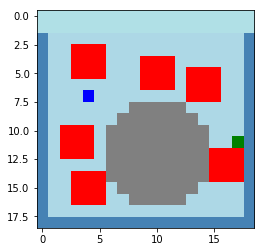

In [8]:
submarine.step(3)
submarine.step(3)
snapshot = submarine.step(3)
plt.imshow(snapshot, cmap=submarine.cmap, norm=submarine.norm)

In [9]:
# _next_state(current_state,action) takes a state and an action as an input and returns the resulting state.
# Note: This function does not update the state of the executing agent.
submarine._next_state((0,0),3)

[0, 1]

# CourseWork

You are to design an agent that will be in charge of the navigation of a submarine, through a
minefield, towards a goal.

Navigating through uncharted territory can be dangerous, which we will model by applying some damage to the submarine. Additionally, there is some uncertainty in the execution of actions when moving through uncharted territory. Currents are very strong and there is a 20% chance that the submarine will diverge away from its path during execution. For example, when going down within the uncharted territory, there is an 80% chance it will go down, but also a 10% chance that it will go left, and another 10% chance it will go right.


Hitting a mine will lead to the destruction of the submarine and boundary regions marked **edge** or **sky** cannot be traversed.  Your task is to develop a strategy for this agent (plotted as the *blue* dot) to safely navigate towards the goal (plotted as the *green* dot).

You are to do this using the principles of Dynamic Programming. In particular, in this exercise,
you will implement the methods of Policy and Value Iteration. For all of these questions, please use
the provided visualisation functions to plot your policies and their associated trajectories. Include
concise comments within the notebook to highlight any interesting observations to support your
answers

## Question 1.1 : Reward and Transition Functions

Define suitable reward and transition functions for the submarine environment. This is a key task for you as the
designer of this agent. 

The reward function specifies a scalar reward for every state in the environment (in accordance to the coursework description above) and the transition function determines the next *probable* state, $s'$, reached when an action $a$ is taken from state $s$.

In [10]:
# HINT: Example reward function
R

array([[-10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.],
       [-10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.],
       [-10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -10.],
       [-10.,   0.,   0.,  -5.,  -5.,  -5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -10.],
       [-10.,   0.,   0.,  -5.,  -5.,  -5.,   0.,   0.,   0.,  -5.,  -5.,  -5.,   0.,   0.,   0.,   0.,   0.,   0., -10.],
       [-10.,   0.,   0.,  -5.,  -5.,  -5.,   0.,   0.,   0.,  -5.,  -5.,  -5.,   0.,  -5.,  -5.,  -5.,   0.,   0., -10.],
       [-10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  -5.,  -5.,  -5.,   0.,  -5.,  -5.,  -5.,   0.,   0., -10.],
       [-10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  -5.,  -5.,  -5.,   0.,   0., -10.],
       [-10.,   

## Question 1.2: Value Iteration


Your first algorithmic task will be to apply value iteration to the solution of this navigation task, using the reward and transition functions you have devised in the previous section.

In [11]:
# HINT: Example Iteration Template
V = np.zeros_like(submarine.maze)
V_sum = 0
discount = 0.8
for i in range(10000):
    for state, region in np.ndenumerate(submarine.maze):
        
        #Bellman Update
        
        
    if (i % 10) == 0:
        if np.abs(V.sum() - V_sum) < 1e-6:
            print(f'Value iteration converged at iteration #{i+1:,}')
            break
        V_sum = V.sum()
   

Value iteration converged at iteration #121


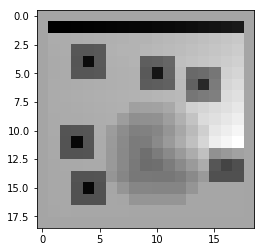

In [12]:
plt.imshow(V,cmap='gray')

In [13]:
## HINT: You will also need to create a deterministic policy using the optimal value function
policy = np.zeros_like(V)

for state, region in np.ndenumerate(submarine.maze):
    for action in range(submarine.num_actions):
        next_state = tuple(submarine._next_state(state,action))
        
    #select the best action based on the highest state-action value
    

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


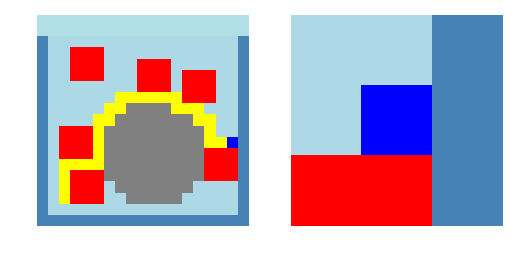

In [14]:
# You should visulise some trajectories from a few different initial points within the environment (e.g. [23,23], [23,5], [6,4],[6,23])
submarine.init_state = [16,2] #[3,16] #[13,2] [4,13]
submarine.reset()
state = submarine.init_state
indx = 0
while state not in submarine.goal_states:
    submarine.step(policy[tuple(state)])
    fig = submarine.render()
    state = submarine.state
    
    if indx > 1000:
        print("Max Iteration Limit Hit!")
        break
    indx += 1
anime = submarine._get_video(interval=200, gif_path='value_iter.mp4').to_html5_video()
HTML(anime)


In [15]:
# Trajectories can also be visualied via the simulate function 
# (note: function buggy on some systems; needs to be run thrice. )
submarine.policy = policy
HTML(simulate(submarine, [3,1]))

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [16]:
# Lets plot the final policy
draw_policy(submarine, policy)

array([['·', '·', '·', '·', '·', '·', '·', '·', '·', '·', '·', '·', '·', '·', '·', '·', '·', '·', '·'],
       ['·', '·', '·', '·', '·', '·', '·', '·', '·', '·', '·', '·', '·', '·', '·', '·', '·', '·', '·'],
       ['·', '→', '→', '→', '→', '→', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '·'],
       ['·', '→', '↑', 'X', 'X', 'X', '→', '→', '→', '→', '→', '→', '↓', '↓', '↓', '↓', '↓', '↓', '·'],
       ['·', '→', '↑', 'X', 'X', 'X', '→', '→', '↑', 'X', 'X', 'X', '→', '→', '→', '→', '↓', '↓', '·'],
       ['·', '↓', '↓', 'X', 'X', 'X', '→', '→', '↑', 'X', 'X', 'X', '↑', 'X', 'X', 'X', '↓', '↓', '·'],
       ['·', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', 'X', 'X', 'X', '↑', 'X', 'X', 'X', '↓', '↓', '·'],
       ['·', '→', '→', '→', '→', '→', '→', '→', '→', '→', '→', '→', '↓', 'X', 'X', 'X', '↓', '↓', '·'],
       ['·', '→', '→', '→', '→', '→', '→', '↑', 'U', 'U', 'U', 'U', 'U', '→', '↓', '↓', '↓', '↓', '·'],
       ['·', '→', '→', '→', '→', '→', '↑', 'U', 'U', 'U', 'U', '

## Question 1.3: Policy Evaluation
    
Define a function that computes the state-value function $V^\pi$ on this environment when given a random policy $\pi$.

## Question 1.4: Policy Iteration
Apply policy iteration to solve the submarine navigation task. 
- In what ways are the results of policy iteration different from those of value iteration?

## Question 1.5: Hyper-parameters

For both policy and value iteration:
- How does varying the discount factor $\gamma$ affect the calculated policy? 
    - Repeat the same experiment with at least three different settings of a discount factor in order to make your argument.
- Given the insights from your experiment above, suggest a suitable strategy for setting an appropriate discount rate?

## Question 1.6: Noisy trigger

The mines now have a 50% chance of blowing up if you are within their direct vicinity (i.e. on their border). 

How does this affect your policy? 

Implement this and justify your answer based on the results.

# Question 2:
*Remark: This second question need not be implemented in the notebook, in the same way you
wrote programs for the first question. Instead, we expect to see a complete problem formulation,
with suitable expressions and graphs, and an explanation of the solution procedure in terms of those
expressions. The notebook only provides a means by which to explore the question; this question should be completed by hand.*


Now consider two additions to the above problem specification, that are common in realistic versions
of this problem:
1. The agent must include within the costs, the ides of navigability - describing the fact that
some parts of a given map are easier to travel through than others (typically, due to the ‘diffi-
culty’ of performing low-level control with respect to the terrain features found at that depth).
One way to model this would be to include a distribution of costs over the given terrain map.
By re-writing your complete problem specification, explain how you will incorporate this
feature in your modelling.
2. The agents in the environment, previously viewed as static obstacles defining where you can
and can not traverse, could have their own dynamics. For instance, one of the mines could be
an active craft with its own motion policy. Assuming that you can observe the current position
of this active craft through a noisy channel (e.g., by interpretation of sonar reflections), pose
your - now interactive - motion planning problem in Bayesian terms and explain how your
solution strategy might need to be altered.
